# **CRISP-DM — Portfolio & Long-Lived Series (PS3→PS4→PS5)**

## **Step 1: Business Understanding**

### **Problem**
We want to understand how sequel performance changes across console generations and which publishers are the most stable over time.

### **Main Questions**
- **Q1:** Do sequels grow or decline when moving from `PS3 to PS4` and `PS4 to PS5`?
- **Q2:** Which publishers show stable results across multiple years?

### **Objectives**
- **O1:** Build a Series Performance Index normalized inside each `platform × year`.
- **O2:** Measure sequel delta (Part N+1 − Part N) and the generation jump effect.
- **O3:** Rank publishers by `stability` (high median, low variance).

### **Success Criteria**
- At least 10 series with 3 or more entries analysed.
- Top 10 publishers ranked by stability (median high, spread low).
- At least 5 clear visuals that support the conclusions.

### **Scope**
**In:** `PS3`, `PS4`, `PS5` titles, series or franchise grouping, release year, publisher, global sales or revenue (used only for normalization).  
**Out:** exact unit forecasts and causal claims; non-PlayStation platforms are outside the main focus.

### **Data (expected)**
- Game title  
- Series / franchise  
- Part number  
- Publisher  
- Platform (PS3 / PS4 / PS5)  
- Release year or date  
- Global sales or revenue  
- Optional: ratings, price

### **Deliverables**
- Colab notebook structured by CRISP-DM.
- Tables for **sequel deltas** and **publisher stability**.
- Figures for **series lines**, **generation boxplots**, and **stability ranking**.
- Short, actionable insights.


## **Step 2: Data Understanding**

### **What we do here**
- Load `vgsales.csv` and standardize column names.
- Use the `Year`, `Platform`, and `Publisher` columns.
- Normalize platform text and map to generations: `PS3, PS4, PS5, Other`.
- Build quick views to understand dataset shape.

### **Key views**
- Releases by generation over years  
  Line chart: Year on X, number of games on Y, separate lines for PS3, PS4, PS5, Other.
- Top publishers by number of games
  Horizontal bar chart of the most active publishers.

### **Notes**
- Rows with missing `Year` are removed.
- All platforms are kept, but the main focus later will be on PS3/PS4/PS5.
- This step is only about structure and distribution, not yet about performance index or sequels.


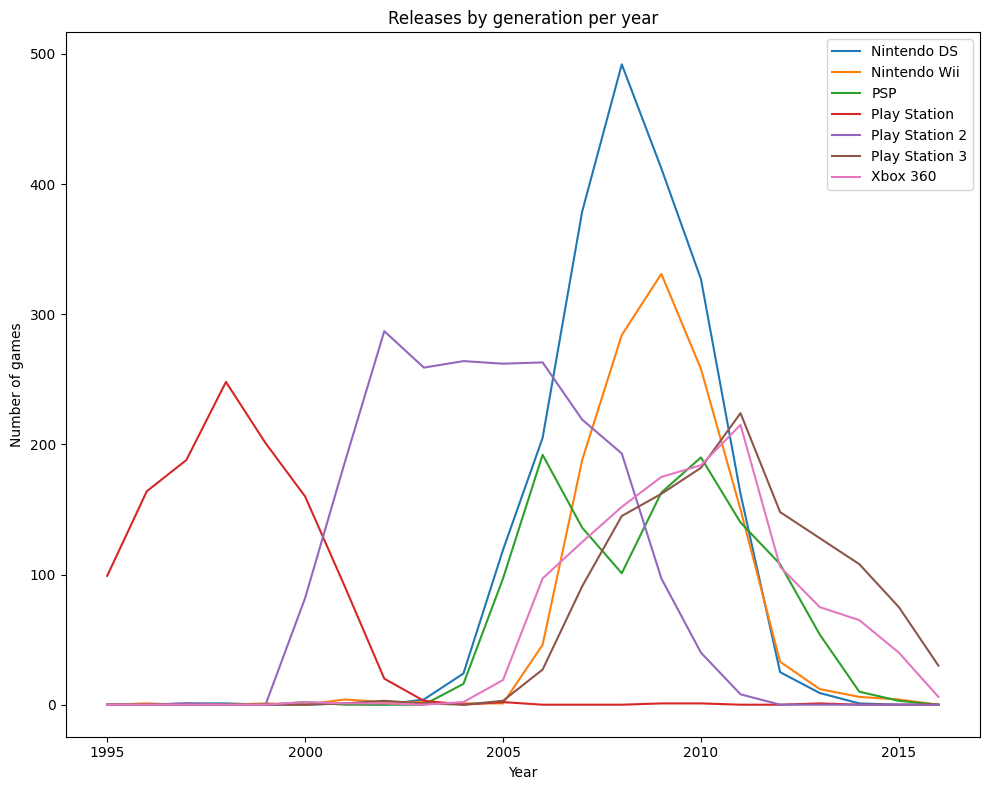

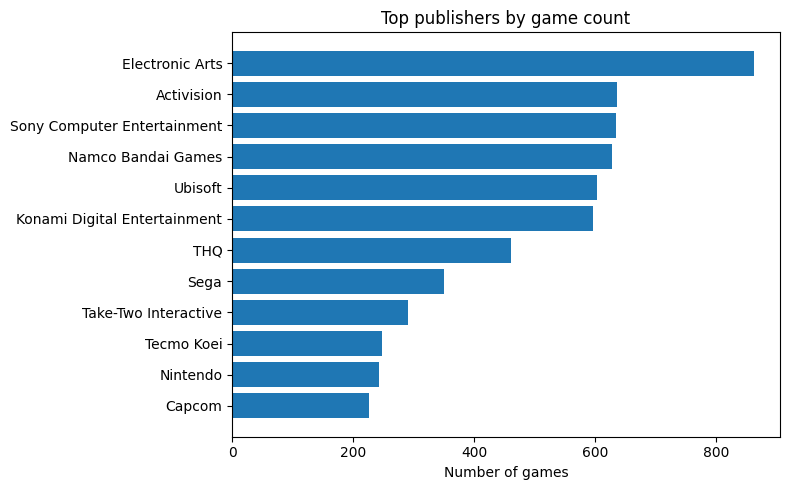

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('vgsales.csv')
df = df.dropna(subset=['Year'])
df['Year'] = df['Year'].astype(int)
df['Platform'] = df['Platform'].astype(str)

df = df[df['Year'] >= 1995]

platform_counts = df['Platform'].value_counts()
popular_platforms = platform_counts[platform_counts >= 1100].index

df = df[df['Platform'].isin(popular_platforms)]

rel = df.pivot_table(index='Year', columns='Platform', values='Name', aggfunc='count').fillna(0).sort_index()

plt.figure(figsize=(10, 8))
for c in rel.columns:
  plt.plot(rel.index, rel[c], label=c)

plt.xlabel('Year')
plt.ylabel('Number of games')
plt.title('Releases by generation per year')
plt.legend()
plt.tight_layout()
plt.show()

top_pub = df['Publisher'].fillna('Unknown').value_counts().head(12).sort_values()

plt.figure(figsize=(8, 5))
plt.barh(top_pub.index, top_pub.values)
plt.xlabel('Number of games')
plt.title('Top publishers by game count')
plt.tight_layout()
plt.show()
